In [1]:
import pandas as pd
import numpy as np
import scipy as sp
from datetime import datetime
import pickle
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.tree import DecisionTreeClassifier, plot_tree
from comparers import ModelComparer, plot_decision_boundary
from util import constraint_matrix_to_rules, RuleClassifier, calc_ground_truth_constraints
from surrogate_tree import tree_to_constraint_matrix
from tasks.running_example import make_task, make_test_set
import logging
logging.basicConfig(level=logging.ERROR)

In [2]:
clf_a, clf_b, X, y, feature_names, feature_precisions = make_task()

In [3]:
comparer = ModelComparer(clf_a, clf_b, feature_names)

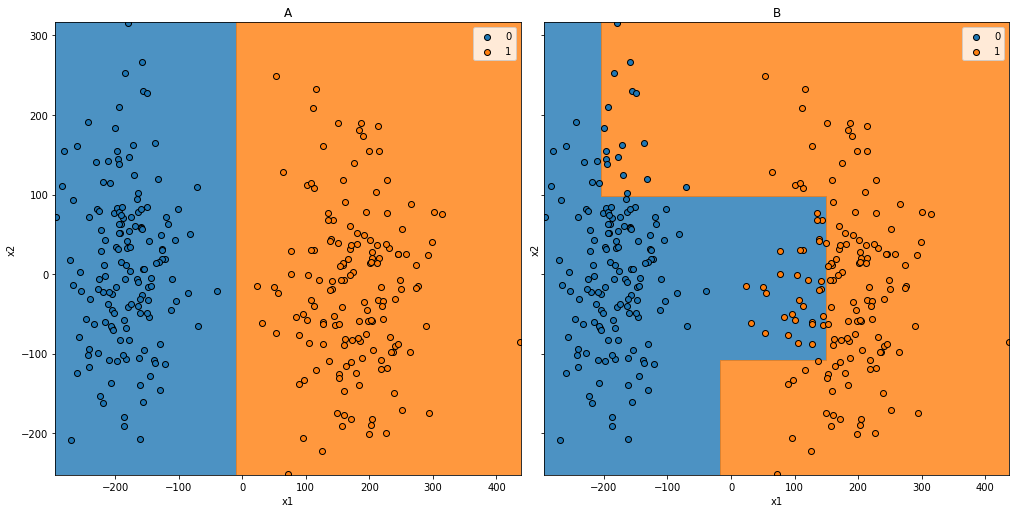

In [4]:
comparer.plot_individual_clf_decision_boundaries(X, y_true=y, kind='label')
plt.savefig('running-example-decision-boundaries-indiv.pdf')

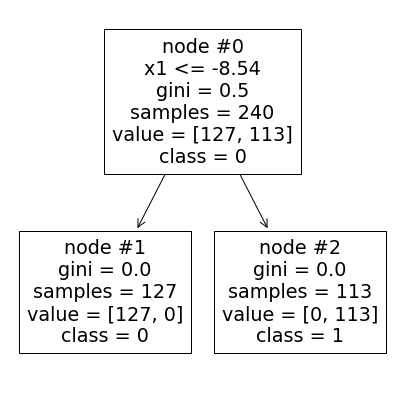

In [5]:
fig, ax = plt.subplots(figsize=(7, 7))
plot_tree(comparer.clf_a, feature_names=comparer.feature_names, class_names=comparer.base_class_names, ax=ax, node_ids=True, precision=2);
plt.savefig('running-example-tree-a.pdf')

Classifier A is a decision tree with just one node. It can be described with one simple rule.

In [6]:
constraints_a, class_occurences_a, labels_a, node_ids_a = tree_to_constraint_matrix(clf_a)
rules_a = constraint_matrix_to_rules(constraints_a, feature_names)
rules_a = [rule for rule, label in zip(rules_a, labels_a) if label == 1 ]
rules_a

['x1 > -8.544832229614258']

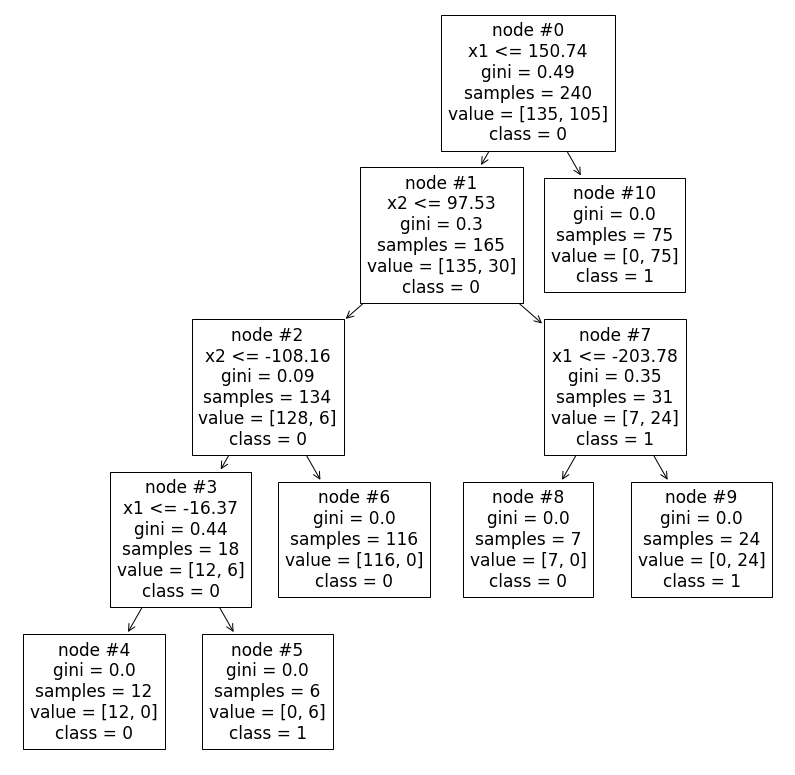

In [7]:
fig, ax = plt.subplots(figsize=(14, 14))
plot_tree(comparer.clf_b, feature_names=comparer.feature_names, class_names=comparer.base_class_names, ax=ax, node_ids=True, precision=2);
plt.savefig('running-example-tree-b.pdf')

Whereas model B needs three rules:

In [8]:
constraints_b, class_occurences_b, labels_b, node_ids_b = tree_to_constraint_matrix(clf_b)
rules_b = constraint_matrix_to_rules(constraints_b, feature_names)
rules_b = [rule for rule, label in zip(rules_b, labels_b) if label == 1 ]
rules_b

['-16.36835479736328 < x1 <= 150.74215698242188 and x2 <= -108.15950393676758',
 '-203.77635192871094 < x1 <= 150.74215698242188 and x2 > 97.53022003173828',
 'x1 > 150.74215698242188']

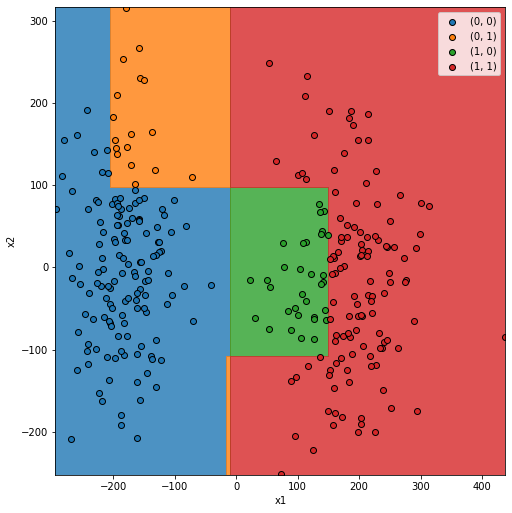

In [9]:
comparer.plot_decision_boundaries(X)
plt.savefig('running-example-diffclf.pdf')

In [10]:
X_test = make_test_set()

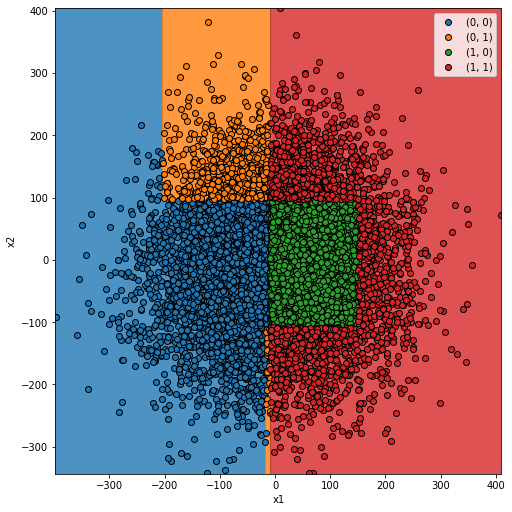

In [11]:
comparer.plot_decision_boundaries(X_test)

In [12]:
constraints_01 = np.array([
    [
        [constraints_b[3, 0, 1], constraints_a[0, 0, 1]],
        [constraints_b[2, 1, 1], np.nan]
    ],
    [
        [constraints_b[1, 0, 0], constraints_a[0, 0, 1]],
        [np.nan, constraints_b[0, 1, 1]]
    ]
])
rules_01 = constraint_matrix_to_rules(constraints_01, feature_names)
for rule_no, rule in enumerate(rules_01, 1):
    print(f'{rule_no}: {rule}')

1: -203.77635192871094 < x1 <= -8.544832229614258 and x2 > 97.53022003173828
2: -16.36835479736328 < x1 <= -8.544832229614258 and x2 <= -108.15950393676758


In [13]:
constraints_10 = np.array([
    [
        [constraints_a[0, 0, 1], constraints_b[1, 0, 1]],
        [constraints_b[0, 1, 1], constraints_b[2, 1, 1]]
    ]
])
rules_10 = constraint_matrix_to_rules(constraints_10, feature_names)
for rule_no, rule in enumerate(rules_10, 1):
    print(f'{rule_no}: {rule}')

1: -8.544832229614258 < x1 <= 150.74215698242188 and -108.15950393676758 < x2 <= 97.53022003173828


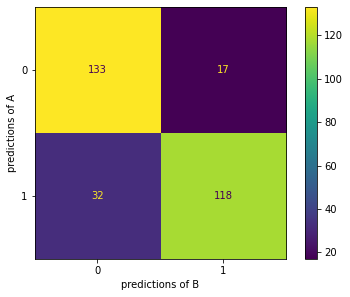

In [14]:
comparer.plot_confusion_matrix(X)
plt.savefig('running-example-cm.pdf')

# Ground Truth

In [32]:
mclass_diff = comparer.predict_mclass_diff(X_test)

In [33]:
rules, constraints = rules_01, constraints_01
label_idx, label_name = comparer.check_class('(0, 1)')

instance_indices = np.where(mclass_diff == label_idx)[0]
ground_truth = np.array([constraints[0] for _ in instance_indices])

with open(f'ground_truth.{label_name}.pickle', 'wb') as f:
    pickle.dump((instance_indices, ground_truth), f)

In [34]:
rules, constraints = rules_10, constraints_10
label_idx, label_name = comparer.check_class('(1, 0)')

instance_indices = np.where(mclass_diff == label_idx)[0]
ground_truth = np.array([constraints[0] for _ in instance_indices])

with open(f'ground_truth.{label_name}.pickle', 'wb') as f:
    pickle.dump((instance_indices, ground_truth), f)

# Special Notes on Evaluation

For this task, there is only one explanation level, the global level.

## Complexity

The complexity metric is calculated excluding rules that target the outlier fidelity to be comparable. For optimal selectiveness, 2 rules and 7 constraints are required in total.

## Outlier Fidelity

Rule 2 of $(0,1)$ is a bonus task: There are no instances in the data set that fall into the range of the rule.

There is an additional test data set with only one instance, which is an outlier. If the rule set is able to correctly classify it (True), it passes this test.

In [18]:
X_test = np.array([[-15, -110]])
comparer.class_names[comparer.predict_mclass_diff(X_test)]

array(['(0, 1)'], dtype='<U6')

In [19]:
rclf = RuleClassifier(feature_names, rules_01)
rclf.predict(X_test)

array([ True])

# Results

In [20]:
with open('results.baseline.pickle', 'rb') as f:
    global_fidelity_baseline, local_fidelity_baseline, complexity_baseline = pickle.load(f)
with open('results.soa.pickle', 'rb') as f:
    global_fidelity_soa, local_fidelity_soa, complexity_soa = pickle.load(f)
with open('results.proposed.pickle', 'rb') as f:
    global_fidelity_proposed, local_fidelity_proposed, complexity_proposed = pickle.load(f)

In [21]:
global_fidelity = pd.concat([global_fidelity_baseline, global_fidelity_soa, global_fidelity_proposed],
                            keys=['BA', 'SOA', 'PA'], names=['approach'])
global_fidelity = global_fidelity.reorder_levels(['class', 'approach']).sort_index()
global_fidelity

Precision  Recall  F1 Score  Support
class  approach                                      
(0, 1) BA              1.0     1.0       1.0       17
       PA              1.0     1.0       1.0       17
       SOA             1.0     1.0       1.0       17
(1, 0) BA              1.0     1.0       1.0       32
       PA              1.0     1.0       1.0       32
       SOA             1.0     1.0       1.0       32

In [22]:
print(global_fidelity.to_latex(float_format="%.2f"))

\begin{tabular}{llrrrr}
\toprule
       &     &  Precision &  Recall &  F1 Score &  Support \\
class & approach &            &         &           &          \\
\midrule
(0, 1) & BA &       1.00 &    1.00 &      1.00 &       17 \\
       & PA &       1.00 &    1.00 &      1.00 &       17 \\
       & SOA &       1.00 &    1.00 &      1.00 &       17 \\
(1, 0) & BA &       1.00 &    1.00 &      1.00 &       32 \\
       & PA &       1.00 &    1.00 &      1.00 &       32 \\
       & SOA &       1.00 &    1.00 &      1.00 &       32 \\
\bottomrule
\end{tabular}



In [23]:
local_fidelity = pd.concat([local_fidelity_baseline, local_fidelity_soa, local_fidelity_proposed],
                             axis=1, keys=['BA', 'SOA', 'PA'], names=['approach', 'metric'])
local_fidelity = local_fidelity.reorder_levels(['metric', 'approach'], axis=1).sort_index(axis=1)
local_fidelity

metric         BAR        BMR             RMSE                    
approach        BA PA SOA  BA PA SOA        BA        PA       SOA
class  feature                                                    
(0, 1) x1        0  0   0   0  0   0  0.000000  0.042442  0.083881
       x2        0  0   0   0  0   0  0.414433  0.030220  0.024010
(1, 0) x1        0  0   0   0  0   0  0.312655  0.049095  0.091702
       x2        0  0   0   0  0   0  7.978202  0.035729  0.021370

In [24]:
print(local_fidelity.to_latex(float_format="%.2f"))

\begin{tabular}{llrrrrrrrrr}
\toprule
       & metric & \multicolumn{3}{l}{BAR} & \multicolumn{3}{l}{BMR} & \multicolumn{3}{l}{RMSE} \\
       & approach &  BA & PA & SOA &  BA & PA & SOA &   BA &   PA &  SOA \\
class & feature &     &    &     &     &    &     &      &      &      \\
\midrule
(0, 1) & x1 &   0 &  0 &   0 &   0 &  0 &   0 & 0.00 & 0.04 & 0.08 \\
       & x2 &   0 &  0 &   0 &   0 &  0 &   0 & 0.41 & 0.03 & 0.02 \\
(1, 0) & x1 &   0 &  0 &   0 &   0 &  0 &   0 & 0.31 & 0.05 & 0.09 \\
       & x2 &   0 &  0 &   0 &   0 &  0 &   0 & 7.98 & 0.04 & 0.02 \\
\bottomrule
\end{tabular}



In [25]:
complexity = pd.concat([complexity_baseline, complexity_soa, complexity_proposed],
                       keys=['BA', 'SOA', 'PA'], names=['approach'])
complexity = complexity.reorder_levels(['class', 'approach']).sort_index()
complexity

Rules  Constraints
class  approach                    
(0, 1) BA            1            3
       PA            1            3
       SOA           1            3
(1, 0) BA            1            4
       PA            1            4
       SOA           1            4

In [26]:
print(complexity.to_latex())

\begin{tabular}{llrr}
\toprule
       &     &  Rules &  Constraints \\
class & approach &        &              \\
\midrule
(0, 1) & BA &      1 &            3 \\
       & PA &      1 &            3 \\
       & SOA &      1 &            3 \\
(1, 0) & BA &      1 &            4 \\
       & PA &      1 &            4 \\
       & SOA &      1 &            4 \\
\bottomrule
\end{tabular}



In [27]:
generation_time = pd.DataFrame({
    'SOA': '37m',
    'BA': '<1s',
    'PA': '1s'}, index=['Time']).T
generation_time

,Time
SOA,37m
BA,<1s
PA,1s


In [28]:
print(generation_time.to_latex())

\begin{tabular}{ll}
\toprule
{} & Time \\
\midrule
SOA &  37m \\
BA  &  <1s \\
PA  &   1s \\
\bottomrule
\end{tabular}



# Further Plots

In [29]:
from explainers import plot_feature_dependence
import shap

In [30]:
with open('indiv.shap', 'rb') as f:
    shap_values = pickle.load(f)

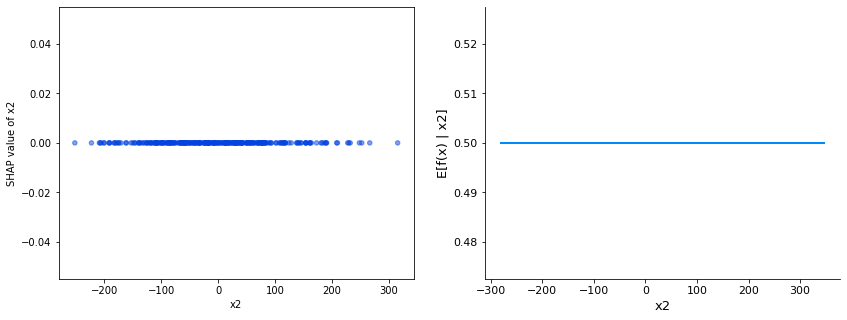

In [35]:
feature_idx, feature_name = comparer.check_feature('x2')
fig, axs = plt.subplots(ncols=2, figsize=(2*7, 5))
plot_feature_dependence(shap_values[:, :, 'A.1'], feature_idx, alpha=0.5, ax=axs[0])
shap.plots.partial_dependence(ind=feature_idx,
                              model=lambda X: comparer.clf_a.predict_proba(X)[:, 1],
                              data=X,
                              feature_names=feature_names,
                              ice=False, hist=False, ax=axs[1])

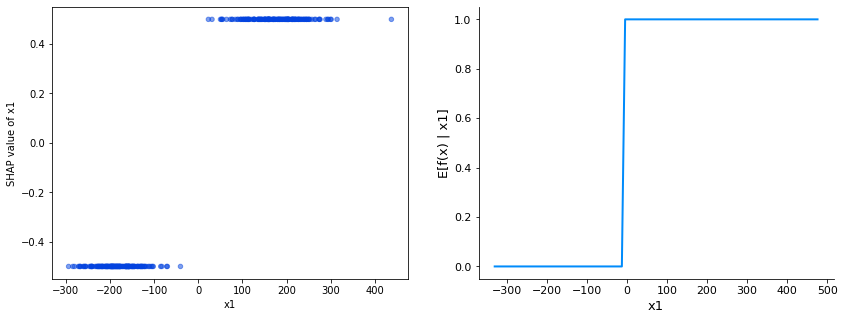

In [36]:
feature_idx, feature_name = comparer.check_feature('x1')
fig, axs = plt.subplots(ncols=2, figsize=(2*7, 5))
plot_feature_dependence(shap_values[:, :, 'A.1'], feature_idx, alpha=0.5, ax=axs[0])
shap.plots.partial_dependence(ind=feature_idx,
                              model=lambda X: comparer.clf_a.predict_proba(X)[:, 1],
                              data=X,
                              feature_names=feature_names,
                              ice=False, hist=False, ax=axs[1])